In [21]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from adabmDCA.utils import get_device, get_dtype

In [3]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float64")

Running on CPU


In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [6]:
# del sequences

In [7]:
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [8]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [35]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/training.py'>

In [36]:
tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

L, q = sequences_oh[0][0].shape
k = torch.zeros(L, q, dtype=dtype, device=device)
Ns0 = energy_models.IndepSites(k)

def mlp(n_hidden):
    return torch.nn.Sequential(
        torch.nn.Linear(L*q, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, 1)
    ).to(dtype=dtype, device=device)

nn = energy_models.GenericEnergyModel(mlp(2))

ps = selex_distribution.MultiModeDistribution(nn, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [37]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [42]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [43]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [44]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [45]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 200

%lprun -f training.train training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                              ] Epoch: 0/200 [00:00, ?it/s]

Timer unit: 1e-09 s

Total time: 2231.8 s
File: /Users/scrotti/Aptamer2025py/training.py
Function: train at line 73

Line #      Hits         Time  Per Hit   % Time  Line Contents
    73                                           def train(
    74                                               model: selex_distribution.MultiRoundDistribution,
    75                                               data_loaders,
    76                                               total_reads,
    77                                               chains: torch.Tensor,
    78                                               n_sweeps: int,
    79                                               lr: float,    
    80                                               max_epochs: int,
    81                                               target_pearson = 0.999,
    82                                               thresh_slope = 1e-2,
    83                                               l2reg: float = 0.0,
    84             

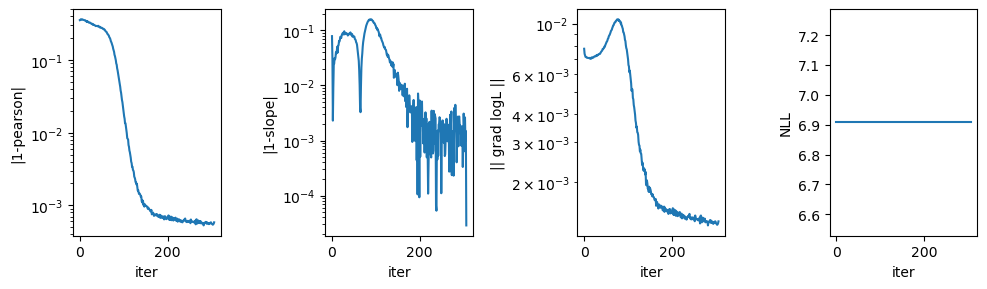

In [20]:
callbacks[0].plot();